In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Data Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Linear
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.feature_selection import SelectFromModel

In [78]:
plt.rcParams["figure.figsize"] = [16,4]

pd.options.display.width = 0
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
np.set_printoptions(threshold=30)

In [79]:
def flatten(nested_lst):
    flattened_lst = [elem for lst in nested_lst for elem in lst]
    return flattened_lst

In [80]:
def prepare_test_data(data, stratify_crit, test_size=0.2, random_state=None):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(data, stratify_crit): # There is no loop really
        data_train = data.iloc[train_index].copy()
        data_test = data.iloc[test_index].copy()
    return data_train, data_test

In [81]:
def prepare_data_for_model(train, val_size=None, random_state=None):
    y = train[features["target"]].to_numpy().reshape(-1)
    X = train.drop(columns=features["target"])
    if val_size is not None:
        return train_test_split(X, y, test_size=val_size, random_state=random_state)
    return X, y

# Data Preparation

In [82]:
housing = pd.read_csv("../data/AmesHousing.csv")

In [83]:
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,

In [84]:
housing.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2928.000000,2928.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2771.000000,2929.000000,2929.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,559.262547,1051.614544,1159.557679,335.455973,4.676792,1499.690444,0.431352,0.061134,1.566553,0.379522,2.854266,1.044369,6.443003,0.599317,1978.132443,1.766815,472.819734,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,439.494153,440.615067,391.890885,428.395715,46.310510,505.508887,0.524820,0.245254,0.552941,0.502629,0.827731,0.214076,1.572964,0.647921,25.528411,0.760566,215.046549,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,219.000000,793.000000,876.250000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,466.000000,990.000000,1084.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,802.000000,1302.000000,1384.000000,703.750000,0.000000,1742.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [85]:
features = {
    "nominal": ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", 
              "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2", 
              "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
              "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", 
              "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"],
    "ordinal": ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", 
              "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", 
              "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", 
              "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", 
              "Paved Drive", "Pool QC", "Fence"],
    "cont": ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", 
                 "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", 
                 "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", 
                 "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"],
    "discrete": ["Order", "Year Built", "Year Remod/Add", "Full Bath", "Half Bath", 
                "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd", "Fireplaces", "Garage Yr Blt", 
                "Garage Cars", "Mo Sold", "Yr Sold"],
    "target": ["SalePrice"]
}

In [86]:
print("Nominal: {}\nOrdinal: {}\nContinuous: {}\nDiscrete: {}".format(
    len(features["nominal"]), len(features["ordinal"]), len(features["cont"]), len(features["discrete"])))

Nominal: 24
Ordinal: 23
Continuous: 19
Discrete: 13


In [87]:
housing["MS Zoning"] = housing["MS Zoning"].apply(str)

In [88]:
nominal_cat_dict = {
    'Lot Config': ["Inside", "Corner", "CulDSac", "FR2", "FR3"],
    'House Style': ["1Story", "1.5Fin", "1.5Unf", "2Story", "2.5Fin", "2.5Unf", "SFoyer", "SLvl"],
    'Land Contour': ["Lvl", "Bnk", "HLS", "Low"],
    'MS SubClass': ["20", "30", "40", "45", "50", "60", "70", "75", "80", "85", "90", "120", "150", "160", "180", "190"],
    'Exterior 2nd': ["AsbShng", "AsphShn", "Brk Cmn", "BrkFace", "CBlock", "CmentBd", "HdBoard", "ImStucc", 
                     "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "Wd Shng"],
    'Garage Type': ["2Types", "Attchd", "Basment", "BuiltIn", "CarPort", "Detchd", "NA"],
    'Misc Feature': ["Elev", "Gar2", "Othr", "Shed", "TenC", "NA"],
    'Street': ["Grvl", "Pave"],
    'Roof Matl': ["ClyTile", "CompShg", "Membran", "Metal", "Roll", "Tar&Grv", "WdShake", "WdShngl"],
    'Sale Type': ["WD ", "CWD", "VWD", "New", "COD", "Con", "ConLw", "ConLI", "ConLD", "Oth"],
    'Sale Condition': ["Normal", "Abnorml", "AdjLand", "Alloca", "Family", "Partial"],
    'Alley': ["Grvl", "Pave", "NA"],
    'Condition 2': ["Artery", "Feedr", "Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe", "RRAe"],
    'Exterior 1st': ["AsbShng", "AsphShn", "BrkComm", "BrkFace", "CBlock", "CemntBd", "HdBoard", "ImStucc", 
                     "MetalSd", "Other", "Plywood", "PreCast", "Stone", "Stucco", "VinylSd", "Wd Sdng", "WdShing"],
    'Neighborhood': ["Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr", "Crawfor", "Edwards", 
                     "Gilbert", "Greens", "GrnHill", "IDOTRR", "Landmrk", "MeadowV", "Mitchel", "NAmes", 
                     "NoRidge", "NPkVill", "NridgHt", "NWAmes", "OldTown", "SWISU", "Sawyer", "SawyerW", 
                     "Somerst", "StoneBr", "Timber", "Veenker"],
    'Roof Style': ["Flat", "Gable", "Gambrel", "Hip", "Mansard", "Shed"],
    'Foundation': ["BrkTil", "CBlock", "PConc", "Slab", "Stone", "Wood"],
    'MS Zoning': ["A (agr)", "C (all)", "FV", "I (all)", "RH", "RL", "RP", "RM"],
    'Central Air': ["N", "Y"],
    'Heating': ["Floor", "GasA", "GasW", "Grav", "OthW", "Wall"],
    'Bldg Type': ["1Fam", "2fmCon", "Duplex", "TwnhsE", "Twnhs"],
    'Condition 1': ["Artery", "Feedr", "Norm", "RRNn", "RRAn", "PosN", "PosA", "RRNe", "RRAe"],
    'Mas Vnr Type': ["BrkCmn", "BrkFace", "CBlock", "None", "Stone"],
}

In [89]:
ordinal_cat_dict = {
    'Kitchen Qual': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Overall Cond': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Exter Qual': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Fence': ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
    'Bsmt Cond': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Utilities': ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    'Electrical': ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    'Heating QC': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Garage Cond': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Pool QC': ["NA", "Fa", "TA", "Gd", "Ex"],
    'Bsmt Qual': ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    'Paved Drive': ["N", "P", "Y"], 
    'Land Slope': ["Sev", "Mod", "Gtl"], 
    'Lot Shape': ["IR3", "IR2", "IR1", "Reg"], 
    'Functional': ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    'BsmtFin Type 1': ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    'Overall Qual': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'Garage Finish': ["NA", "Unf", "RFn", "Fin"], 
    'BsmtFin Type 2': ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    'Garage Qual': ["NA", "Po", "Fa", "TA", "Gd", "Ex"], 
    'Fireplace Qu': ["NA", "Po", "Fa", "TA", "Gd", "Ex"], 
    'Exter Cond': ["Po", "Fa", "TA", "Gd", "Ex"],
    'Bsmt Exposure': ["NA", "No", "Mn", "Av", "Gd"]
}

In [90]:
def get_categories(data):
    ordinal_categories = [ordinal_cat_dict[key] for key in data[features["ordinal"]].columns]
    nominal_categories = [nominal_cat_dict[key] for key in data[features["nominal"]].columns]
    return ordinal_categories, nominal_categories

In [91]:
nas = housing.isna().sum()
nas = nas[nas > 0].sort_values(ascending=False)
nas

Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Fireplace Qu      1422
Lot Frontage       490
Garage Yr Blt      159
Garage Cond        159
Garage Qual        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Cond           80
Bsmt Qual           80
BsmtFin Type 1      80
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Bsmt Unf SF          1
Total Bsmt SF        1
Garage Area          1
Electrical           1
dtype: int64

In [92]:
tofill_features = [
    'Pool QC', 'Misc Feature', 'Alley', 'Fence', 
    'Fireplace Qu', 'Garage Qual', 'Garage Cond', 'Garage Finish', 
    'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 2',
    'BsmtFin Type 1', 'Bsmt Cond', 'Bsmt Qual']

housing[tofill_features] = housing[tofill_features].fillna("NA")

In [93]:
def drop_features_from_dict(features, discarded):
    for key in features:
        for feat in discarded:
            if feat in features[key]:
                features[key].remove(feat)

In [94]:
discarded_features = ['PID', 'Order', 'Garage Yr Blt', 'Mas Vnr Type', 'Mas Vnr Area', 'Lot Frontage', 'MS SubClass']
drop_features_from_dict(features, discarded_features)
housing = housing.drop(columns=discarded_features)

In [95]:
housing = housing.dropna()

In [96]:
housing.isna().sum().sort_values().tail()

Exter Qual      0
Exterior 2nd    0
Exterior 1st    0
Roof Style      0
SalePrice       0
dtype: int64

In [97]:
all_features = features["target"]+features["cont"]+features["discrete"]+features["ordinal"]+features["nominal"]
housing = housing[all_features]

In [98]:
housing[features["cont"]] = housing[features["cont"]].astype("float64")
housing[features["discrete"]] = housing[features["discrete"]].astype("int64")

In [99]:
ordinal_categories, nominal_categories = get_categories(housing)

In [100]:
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
housing_ord = ordinal_encoder.fit_transform(housing[features["ordinal"]])
housing[features["ordinal"]] = housing_ord
housing[features["ordinal"]] = housing[features["ordinal"]].astype("int64")

In [101]:
criteria = pd.cut(housing["SalePrice"], bins=20, labels=range(20))
train, test = prepare_test_data(housing, stratify_crit=criteria, random_state=99)

In [102]:
train_du = pd.get_dummies(train, columns=features["nominal"], drop_first=False)

In [103]:
train_df = pd.get_dummies(train, columns=features["nominal"], drop_first=True)

# Exploration

In [468]:
data = train.copy()

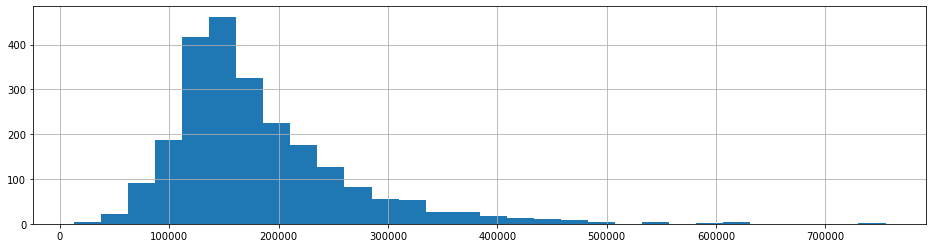

In [447]:
data["SalePrice"].hist(bins=30);

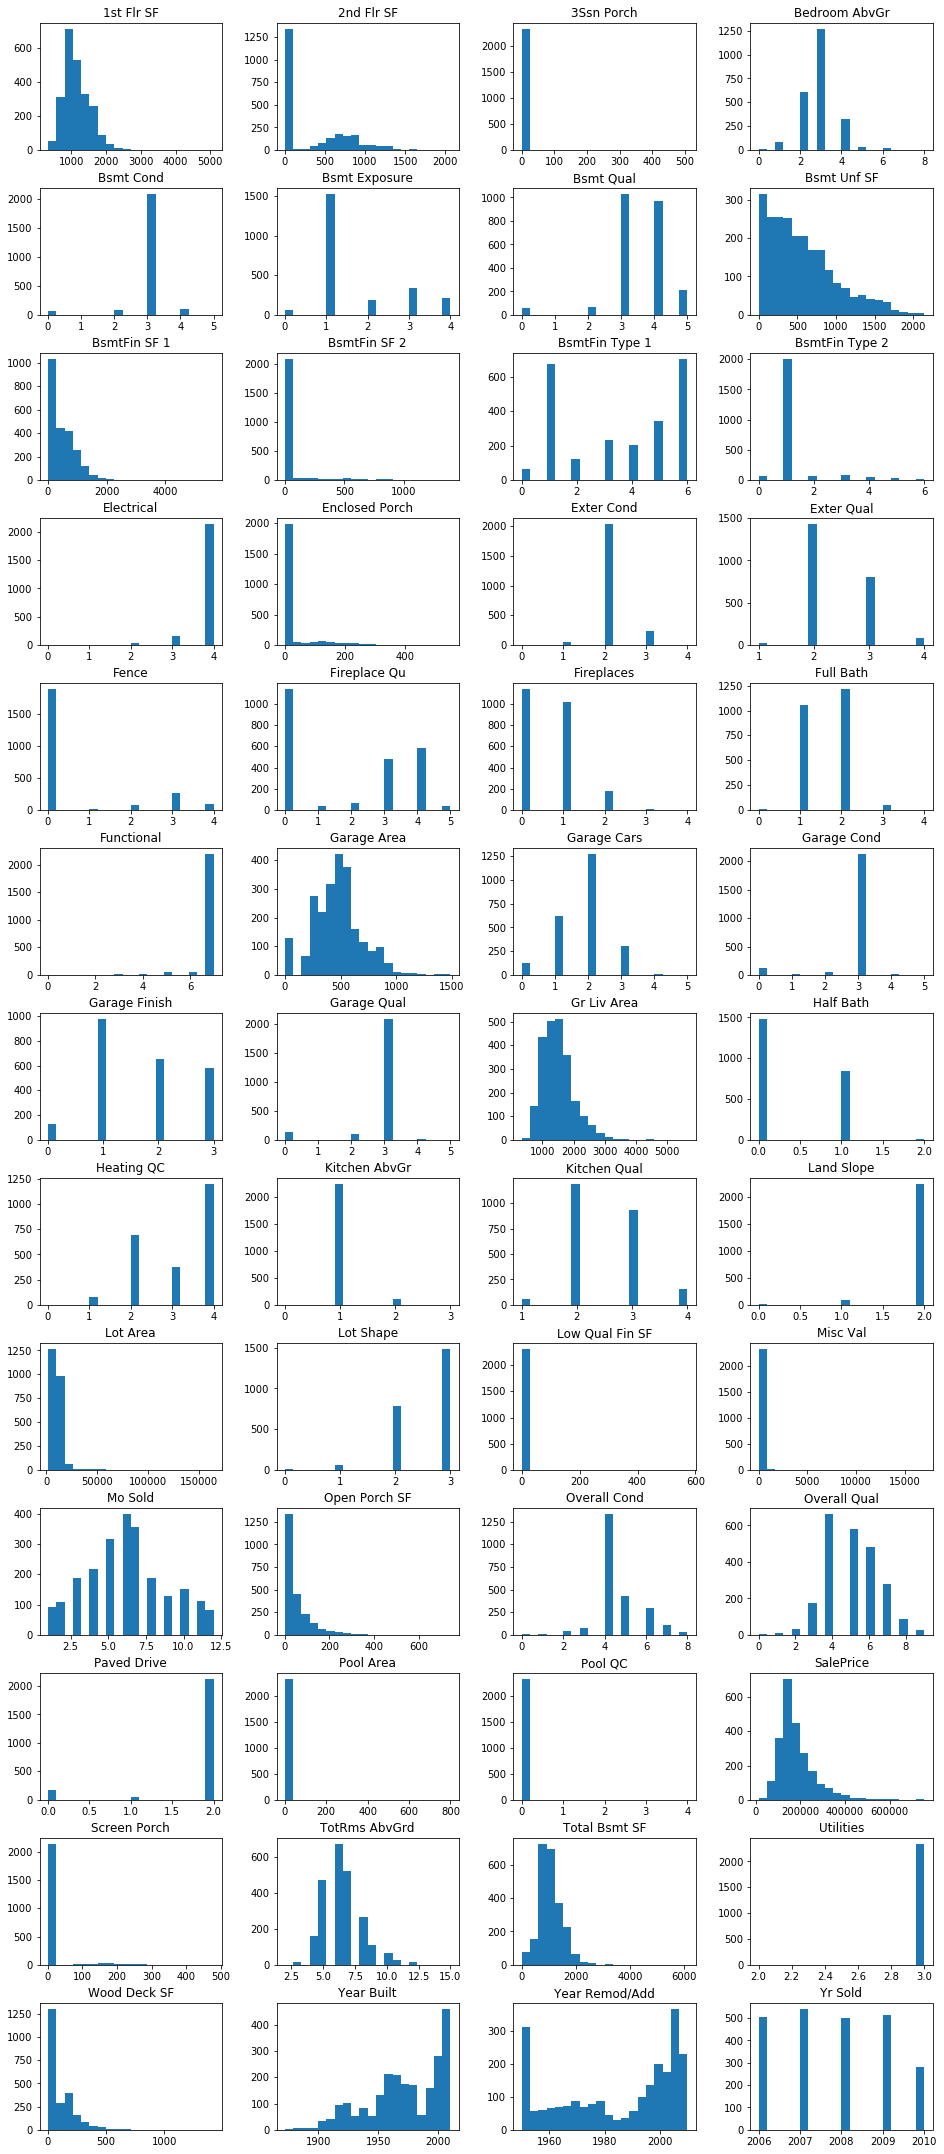

In [436]:
data.hist(figsize=(16,60), layout=(20,4), bins=20, grid=False);

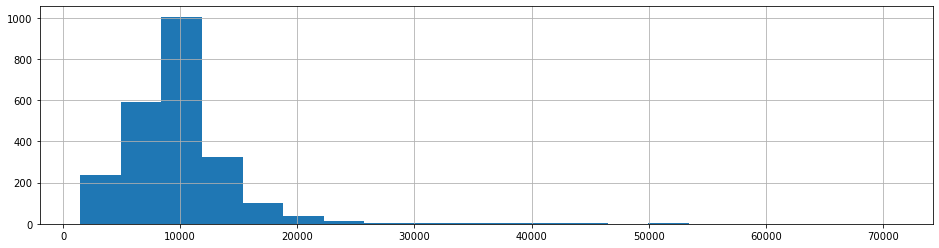

In [496]:
data["Lot Area"].hist(bins=20)

In [492]:
data.sort_values(by="Lot Area").tail(10)

,SalePrice,Lot Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Year Built,Year Remod/Add,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Mo Sold,Yr Sold,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Foundation,Heating,Central Air,Garage Type,Misc Feature,Sale Type,Sale Condition
1637,591587,51974.0,1101.0,0.0,1559.0,2660.0,2338.0,0.0,0.0,2338.0,1110.0,0.0,135.0,0.0,0.0,322.0,0.0,0.0,2006,2007,2,1,4,1,8,2,3,6,2007,2,3,2,8,4,4,2,5,3,3,6,1,4,4,3,7,4,3,4,3,2,0,0,RL,Pave,NA,Lvl,CulDSac,StoneBr,PosN,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,New,Partial
2116,240000,53107.0,985.0,0.0,595.0,1580.0,1079.0,874.0,0.0,1953.0,501.0,216.0,231.0,0.0,0.0,0.0,0.0,0.0,1992,1992,2,1,3,1,9,2,2,6,2007,1,3,1,5,4,3,2,4,3,3,6,1,4,4,3,7,2,3,3,3,2,0,0,RL,Pave,NA,Low,Corner,ClearCr,Feedr,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,PConc,GasA,Y,Attchd,NA,WD,Normal
1402,256000,53227.0,1116.0,0.0,248.0,1364.0,1663.0,0.0,0.0,1663.0,529.0,224.0,137.0,0.0,0.0,0.0,0.0,0.0,1954,1994,1,0,2,1,6,2,2,3,2008,2,3,1,3,5,2,2,4,3,4,4,1,4,4,3,6,4,3,3,3,2,0,0,RL,Pave,NA,Low,CulDSac,ClearCr,Norm,Norm,1Fam,1Story,Flat,Tar&Grv,Plywood,Plywood,CBlock,GasA,Y,Attchd,NA,WD,Normal
15,538000,53504.0,1416.0,0.0,234.0,1650.0,1690.0,1589.0,0.0,3279.0,841.0,503.0,36.0,0.0,0.0,210.0,0.0,0.0,2003,2003,3,1,4,1,12,1,3,6,2010,1,3,1,7,4,4,2,4,3,4,5,1,4,4,4,4,4,3,3,3,2,0,0,RL,Pave,NA,HLS,CulDSac,StoneBr,Norm,Norm,1Fam,2Story,Hip,CompShg,CemntBd,Wd Shng,PConc,GasA,Y,BuiltIn,NA,WD,Normal
314,160000,57200.0,353.0,334.0,60.0,747.0,1687.0,0.0,0.0,1687.0,572.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,1948,1950,1,0,3,1,7,2,2,6,2010,2,3,0,4,4,2,2,3,3,3,4,3,2,4,2,6,3,1,3,3,0,0,0,RL,Pave,NA,Bnk,Inside,Timber,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,CBlock,GasA,Y,Detchd,NA,WD,Normal
1498,160000,63887.0,5644.0,0.0,466.0,6110.0,4692.0,950.0,0.0,5642.0,1418.0,214.0,292.0,0.0,0.0,0.0,480.0,0.0,2008,2008,2,1,3,1,12,3,2,1,2008,0,3,2,9,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,3,0,RL,Pave,NA,Bnk,Corner,Edwards,Feedr,Norm,1Fam,2Story,Hip,ClyTile,Stucco,Stucco,PConc,GasA,Y,Attchd,NA,New,Partial
2766,280000,70761.0,655.0,0.0,878.0,1533.0,1533.0,0.0,0.0,1533.0,576.0,200.0,54.0,0.0,0.0,0.0,0.0,0.0,1975,1975,2,0,2,1,5,2,2,12,2006,2,3,1,6,4,2,2,4,3,4,5,1,2,4,3,7,3,1,3,3,2,0,0,RL,Pave,NA,Low,Inside,ClearCr,Norm,Norm,1Fam,1Story,Gable,WdShngl,Plywood,Plywood,CBlock,GasA,Y,Attchd,NA,WD,Normal
2071,302000,115149.0,1219.0,0.0,424.0,1643.0,1824.0,0.0,0.0,1824.0,739.0,380.0,48.0,0.0,0.0,0.0,0.0,0.0,1971,2002,2,0,2,1,5,2,2,6,2007,1,3,0,6,4,2,2,4,3,4,6,1,2,4,3,7,3,1,3,3,2,0,0,RL,Pave,NA,Low,CulDSac,ClearCr,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,CBlock,GasA,Y,Attchd,NA,WD,Normal
2115,277000,159000.0,697.0,0.0,747.0,1444.0,1444.0,700.0,0.0,2144.0,389.0,0.0,98.0,0.0,0.0,0.0,0.0,500.0,1958,2006,2,0,4,1,7,2,2,6,2007,1,3,0,5,6,3,2,4,3,4,3,1,3,4,3,7,3,3,3,3,2,0,0,RL,Pave,NA,Low,CulDSac,ClearCr,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,HdBoard,CBlock,GasA,Y,Attchd,Shed,WD,Normal
1570,228950,164660.0,1249.0,147.0,103.0,1499.0,1619.0,167.0,0.0,1786.0,529.0,670.0,0.0,0.0,0.0,0.0,0.0,700.0,1965,1965,2,0,3,1,7,2,2,8,2008,2,3,0,4,5,2,2,3,3,4,5,4,4,4,2,7,4,3,3,3,2,0,0,RL,Grvl,NA,HLS,Corner,Timber,Norm,Norm,2fmCon,1.5Fin,Gable,CompShg,Plywood,Plywood,CBlock,GasA,Y,Attchd,Shed,WD,Normal


In [494]:
data.drop(index=[2071, 2115, 1570], inplace=True)

In [500]:
data.sort_values(by="SalePrice").tail(10)

,SalePrice,Lot Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Year Built,Year Remod/Add,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Mo Sold,Yr Sold,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Foundation,Heating,Central Air,Garage Type,Misc Feature,Sale Type,Sale Condition
2330,545224,18062.0,0.0,0.0,1528.0,1528.0,1528.0,1862.0,0.0,3390.0,758.0,204.0,34.0,0.0,0.0,0.0,0.0,0.0,2006,2006,3,1,5,1,10,1,3,9,2006,2,3,2,9,4,4,2,5,3,4,1,1,4,4,4,7,5,3,3,3,2,0,0,RL,Pave,NA,HLS,CulDSac,StoneBr,Norm,Norm,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,PConc,GasA,Y,BuiltIn,NA,New,Partial
423,555000,15431.0,1767.0,539.0,788.0,3094.0,2402.0,0.0,0.0,2402.0,672.0,0.0,72.0,0.0,0.0,170.0,0.0,0.0,2008,2008,2,0,2,1,10,2,3,4,2009,3,3,2,9,4,4,2,5,3,4,6,5,4,4,4,7,4,3,3,3,2,0,0,RL,Pave,NA,Lvl,Inside,NridgHt,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,WD,Normal
2332,556581,16056.0,240.0,0.0,1752.0,1992.0,1992.0,876.0,0.0,2868.0,716.0,214.0,108.0,0.0,0.0,0.0,0.0,0.0,2005,2006,3,1,4,1,11,1,3,7,2006,2,3,2,8,4,3,2,5,3,3,6,1,4,4,4,7,4,3,3,3,2,0,0,RL,Pave,NA,Lvl,Inside,StoneBr,Norm,Norm,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,PConc,GasA,Y,BuiltIn,NA,New,Partial
2450,584500,17242.0,292.0,1393.0,48.0,1733.0,1933.0,1567.0,0.0,3500.0,959.0,870.0,86.0,0.0,0.0,210.0,0.0,0.0,1993,1994,3,1,4,1,11,1,3,5,2006,2,3,2,8,4,3,3,5,3,4,3,6,4,4,4,7,3,2,3,3,2,0,0,RL,Pave,NA,Lvl,Inside,NoRidge,Norm,Norm,1Fam,2Story,Hip,CompShg,MetalSd,MetalSd,PConc,GasA,Y,Attchd,NA,WD,Normal
1637,591587,51974.0,1101.0,0.0,1559.0,2660.0,2338.0,0.0,0.0,2338.0,1110.0,0.0,135.0,0.0,0.0,322.0,0.0,0.0,2006,2007,2,1,4,1,8,2,3,6,2007,2,3,2,8,4,4,2,5,3,3,6,1,4,4,3,7,4,3,4,3,2,0,0,RL,Pave,NA,Lvl,CulDSac,StoneBr,PosN,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,New,Partial
44,611657,12919.0,2188.0,0.0,142.0,2330.0,2364.0,0.0,0.0,2364.0,820.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,2009,2010,2,1,2,1,11,2,3,3,2010,2,3,2,8,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,0,0,RL,Pave,NA,Lvl,Inside,NridgHt,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,New,Partial
1063,615000,12720.0,2257.0,0.0,278.0,2535.0,2470.0,0.0,0.0,2470.0,789.0,154.0,65.0,0.0,0.0,216.0,144.0,0.0,2003,2003,1,1,1,1,7,2,3,2,2008,3,3,1,9,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,4,0,RL,Pave,NA,HLS,Inside,NridgHt,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,PConc,GasA,Y,Attchd,NA,WD,Normal
2445,625000,35760.0,1387.0,0.0,543.0,1930.0,1831.0,1796.0,0.0,3627.0,807.0,361.0,76.0,0.0,0.0,0.0,0.0,0.0,1995,1996,3,1,4,1,10,1,3,7,2006,2,3,2,9,4,3,3,5,3,4,6,1,4,4,3,7,3,3,3,3,2,0,0,RL,Pave,NA,Lvl,CulDSac,NoRidge,Norm,Norm,1Fam,2Story,Hip,CompShg,HdBoard,HdBoard,PConc,GasA,Y,Attchd,NA,WD,Normal
1760,745000,15623.0,2096.0,0.0,300.0,2396.0,2411.0,2065.0,0.0,4476.0,813.0,171.0,78.0,0.0,0.0,0.0,555.0,0.0,1996,1996,3,1,4,1,10,2,3,7,2007,2,3,2,9,4,3,2,5,3,3,6,1,4,4,4,7,3,3,3,3,2,4,3,RL,Pave,NA,Lvl,Corner,NoRidge,Norm,Norm,1Fam,2Story,Hip,CompShg,Wd Sdng,ImStucc,PConc,GasA,Y,Attchd,NA,WD,Abnorml
1767,755000,21535.0,1455.0,0.0,989.0,2444.0,2444.0,1872.0,0.0,4316.0,832.0,382.0,50.0,0.0,0.0,0.0,0.0,0.0,1994,1995,3,1,4,1,10,2,3,1,2007,2,3,2,9,5,4,2,5,3,4,6,1,4,4,4,7,5,3,3,3,2,0,0,RL,Pave,NA,Lvl,Corner,NoRidge,Norm,Norm,1Fam,2Story,Gable,WdShngl,HdBoard,HdBoard,PConc,GasA,Y,Attchd,NA,WD,Normal


In [501]:
data.drop(index=[1760,1767], inplace=True)

In [509]:
data.sort_values(by="BsmtFin SF 1").tail(10)

,SalePrice,Lot Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Year Built,Year Remod/Add,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Mo Sold,Yr Sold,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Foundation,Heating,Central Air,Garage Type,Misc Feature,Sale Type,Sale Condition
366,501837,17423.0,1904.0,0.0,312.0,2216.0,2234.0,0.0,0.0,2234.0,1166.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,2008,2009,2,0,1,1,9,1,3,7,2009,2,3,2,8,4,4,2,5,3,1,6,1,4,4,4,7,4,3,3,3,2,0,0,RL,Pave,NA,Lvl,CulDSac,StoneBr,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,New,Partial
349,375000,7296.0,1965.0,0.0,243.0,2208.0,2522.0,0.0,0.0,2522.0,564.0,182.0,57.0,0.0,0.0,0.0,0.0,0.0,2004,2005,2,0,1,1,8,1,2,11,2009,2,3,2,7,4,3,2,5,3,3,6,1,4,4,3,7,4,3,3,3,2,0,0,RL,Pave,NA,Lvl,CulDSac,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,CemntBd,CmentBd,PConc,GasA,Y,Attchd,NA,WD,Normal
448,445000,15274.0,1972.0,0.0,480.0,2452.0,2452.0,0.0,0.0,2452.0,886.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,2003,2003,2,0,3,1,10,1,3,7,2009,2,3,2,8,4,3,2,5,3,1,6,1,4,4,4,7,4,3,3,3,2,0,3,RL,Pave,NA,Lvl,Corner,NridgHt,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,WD,Normal
1425,475000,11778.0,2085.0,0.0,186.0,2271.0,2276.0,0.0,0.0,2276.0,1348.0,0.0,0.0,70.0,0.0,255.0,0.0,0.0,2008,2008,2,0,3,1,7,2,3,6,2008,3,3,2,8,4,3,2,4,3,4,6,1,4,4,4,7,4,2,4,3,2,0,0,RL,Pave,NA,Lvl,Inside,CollgCr,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,WD,Abnorml
513,468000,11128.0,2158.0,0.0,300.0,2458.0,2490.0,0.0,0.0,2490.0,795.0,70.0,226.0,0.0,0.0,0.0,0.0,0.0,2005,2006,2,0,2,1,9,2,3,10,2009,3,3,2,8,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,0,4,RL,Pave,NA,Lvl,Corner,Somerst,PosN,PosN,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,WD,Normal
44,611657,12919.0,2188.0,0.0,142.0,2330.0,2364.0,0.0,0.0,2364.0,820.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,2009,2010,2,1,2,1,11,2,3,3,2010,2,3,2,8,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,0,0,RL,Pave,NA,Lvl,Inside,NridgHt,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,PConc,GasA,Y,Attchd,NA,New,Partial
1063,615000,12720.0,2257.0,0.0,278.0,2535.0,2470.0,0.0,0.0,2470.0,789.0,154.0,65.0,0.0,0.0,216.0,144.0,0.0,2003,2003,1,1,1,1,7,2,3,2,2008,3,3,1,9,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,4,0,RL,Pave,NA,HLS,Inside,NridgHt,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,PConc,GasA,Y,Attchd,NA,WD,Normal
2181,184750,40094.0,2260.0,0.0,878.0,3138.0,3138.0,1538.0,0.0,4676.0,884.0,208.0,406.0,0.0,0.0,0.0,0.0,0.0,2007,2008,3,1,3,1,11,1,3,10,2007,2,3,2,9,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,0,0,RL,Pave,NA,Bnk,Inside,Edwards,PosN,PosN,1Fam,2Story,Hip,CompShg,CemntBd,CmentBd,PConc,GasA,Y,BuiltIn,NA,New,Partial
2180,183850,39290.0,4010.0,0.0,1085.0,5095.0,5095.0,0.0,0.0,5095.0,1154.0,546.0,484.0,0.0,0.0,0.0,0.0,17000.0,2008,2009,2,1,2,1,15,2,3,10,2007,2,3,2,9,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,0,0,RL,Pave,NA,Bnk,Inside,Edwards,Norm,Norm,1Fam,1Story,Hip,CompShg,CemntBd,CmentBd,PConc,GasA,Y,Attchd,Elev,New,Partial
1498,160000,63887.0,5644.0,0.0,466.0,6110.0,4692.0,950.0,0.0,5642.0,1418.0,214.0,292.0,0.0,0.0,0.0,480.0,0.0,2008,2008,2,1,3,1,12,3,2,1,2008,0,3,2,9,4,4,2,5,3,4,6,1,4,4,4,7,4,3,3,3,2,3,0,RL,Pave,NA,Bnk,Corner,Edwards,Feedr,Norm,1Fam,2Story,Hip,ClyTile,Stucco,Stucco,PConc,GasA,Y,Attchd,NA,New,Partial


In [510]:
data.drop(index=[2180, 1498], inplace=True)

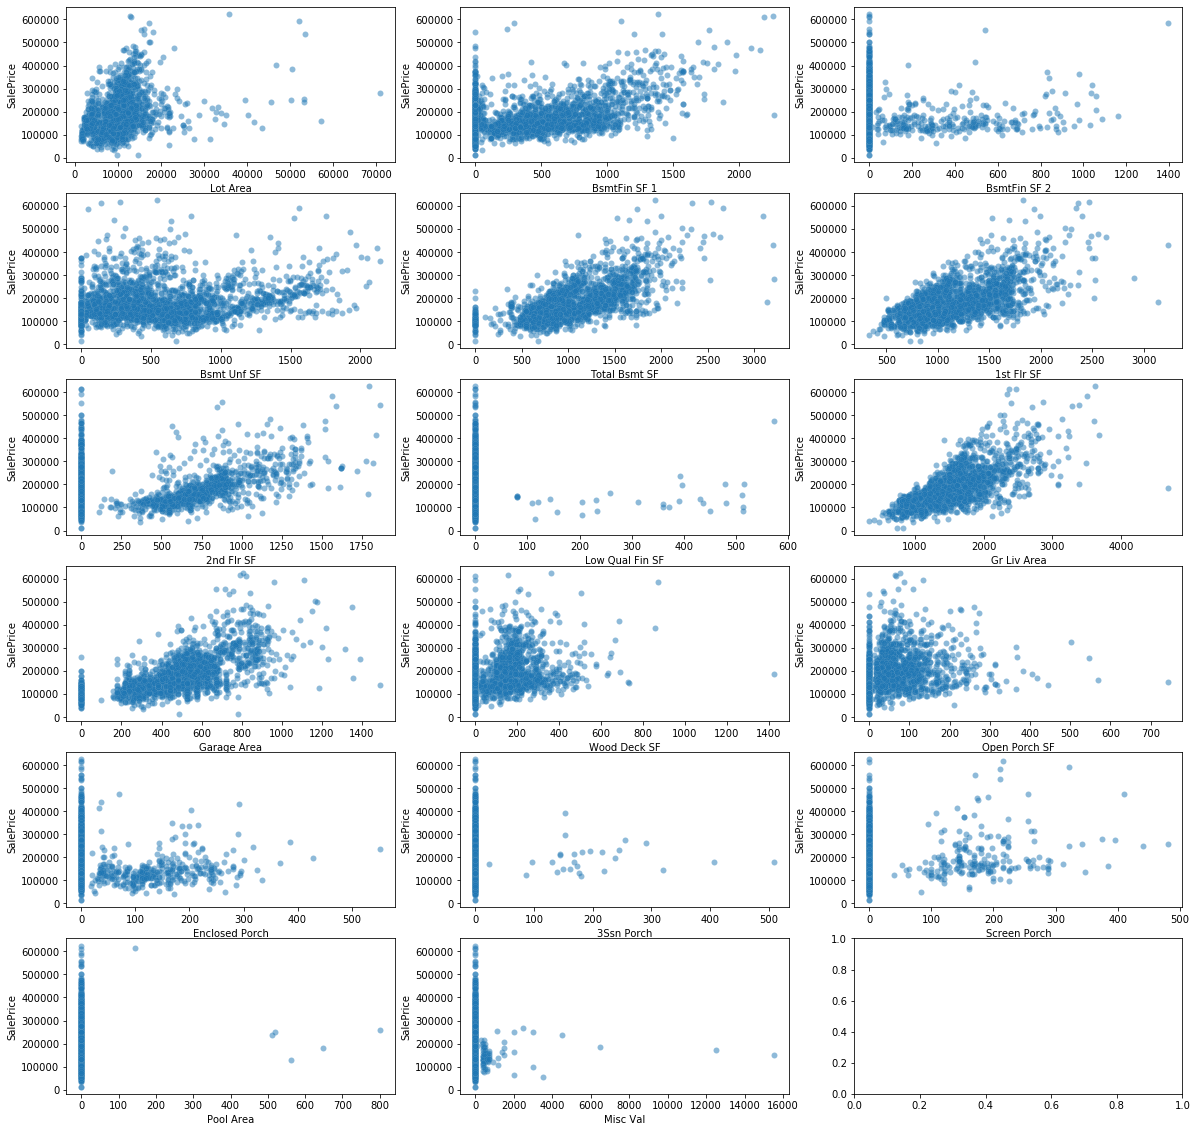

In [511]:
f, ax = plt.subplots(6, 3, figsize=(20,20))
to_plot = zip(flatten(ax), features["cont"])
for ax, feature in to_plot:
    sns.scatterplot(data=data, y="SalePrice", x=feature, ax=ax, alpha=0.5, linewidth=0.1)

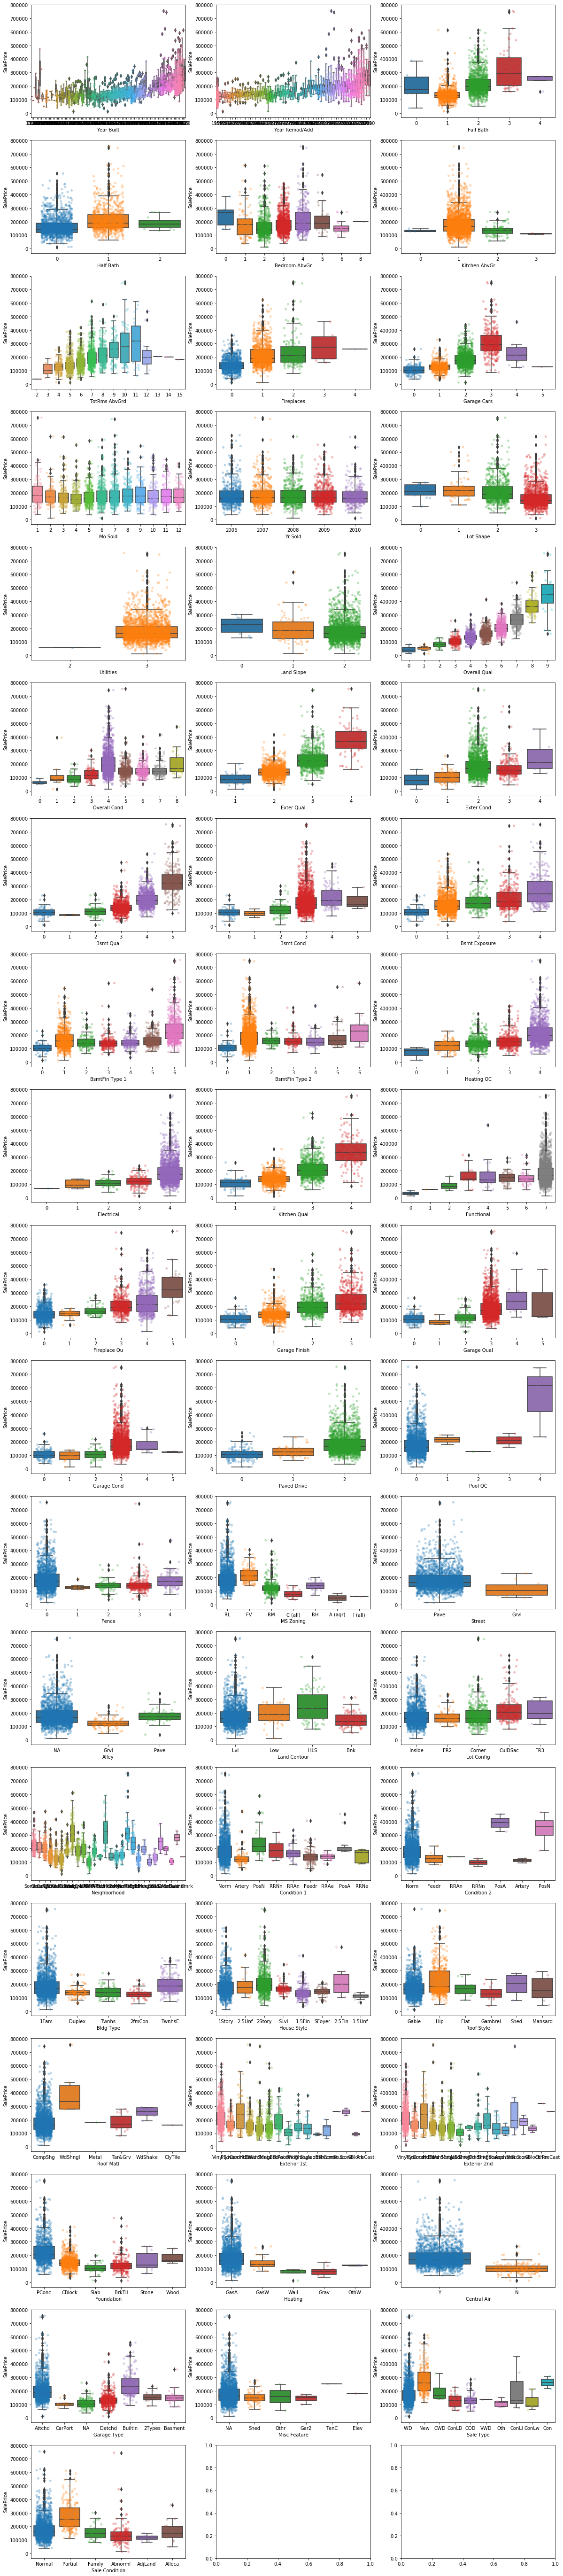

In [378]:
f, ax = plt.subplots(19, 3, figsize=(20,100))
to_plot = zip(flatten(ax), features["discrete"]+features["ordinal"]+features["nominal"])
for ax, feature in to_plot:
    sns.boxplot(y="SalePrice", x=feature, data=data, ax=ax)
    sns.stripplot(y="SalePrice", x=feature, data=data, ax=ax, jitter=0.3, alpha=0.3)

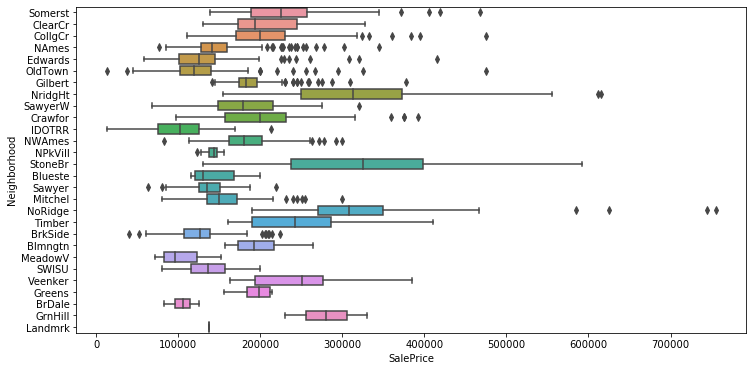

In [398]:
plt.figure(figsize=(12,6))
sns.boxplot(x="SalePrice", y="Neighborhood", data=data);

# Decision Tree

In [238]:
def score_model(model, X, y, metrics, cv=10):
    cv_scores = cross_validate(model, X, y, cv=cv, scoring=list(metrics.values()), n_jobs=-1)
    for key, value in metrics.items():   
        print("{}: {}".format(key, cv_scores['test_'+value].mean()))

In [223]:
y = train_du[features["target"]].to_numpy().reshape(-1)
X = train_du.drop(columns=features["target"])

In [224]:
metrics = {'R2':'r2', 'MAE':'neg_mean_absolute_error', 'RMSE':'neg_root_mean_squared_error'}

In [225]:
model_tree = DecisionTreeRegressor()
score_model(model_tree, X, y, metrics)

R2: 0.8066975611422584
MAE: -23352.157264957266
RMSE: -34718.76754745363


In [226]:
model_tree.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [227]:
important_features_idx = np.flip(np.argsort(model_tree.feature_importances_))
important_features_names = X.columns[important_features_idx]
importances = model_tree.feature_importances_[important_features_idx]
feature_scores = list(zip(important_features_names, importances))

[(name, score) for name, score in feature_scores if score >= 0.01]

[('Overall Qual', 0.6748547363373264),
 ('Gr Liv Area', 0.0952135135989877),
 ('1st Flr SF', 0.04055735195778373),
 ('2nd Flr SF', 0.0314858700360844),
 ('Total Bsmt SF', 0.027511964447247517),
 ('BsmtFin SF 1', 0.01412032213569318),
 ('Lot Area', 0.01330088157672908),
 ('Garage Cars', 0.011578690142927213),
 ('Garage Area', 0.010104135973986197)]

In [228]:
select_features = SelectFromModel(model_tree, threshold=0.01, prefit=True)
X_tree = select_features.transform(X)

In [229]:
score_model(model_tree, X_tree, y, metrics)

R2: 0.8035305600538006
MAE: -24615.01809116809
RMSE: -35002.35797164534


# Random Forest

In [230]:
y = train_du[features["target"]].to_numpy().reshape(-1)
X = train_du.drop(columns=features["target"])

In [231]:
model_forest = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
score_model(model_forest, X, y, metrics)

R2: 0.9003174843805907
MAE: -15398.244466666667
RMSE: -24823.015446550475


In [232]:
model_forest.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [233]:
important_features_idx = np.flip(np.argsort(model_forest.feature_importances_))
important_features_names = X.columns[important_features_idx]
importances = model_forest.feature_importances_[important_features_idx]
feature_scores = list(zip(important_features_names, importances))

[(name, score) for name, score in feature_scores if score >= 0.01]

[('Overall Qual', 0.6533134557204867),
 ('Gr Liv Area', 0.10322462281806188),
 ('Total Bsmt SF', 0.02885648797877208),
 ('1st Flr SF', 0.02591731570378965),
 ('2nd Flr SF', 0.02242469935112661),
 ('BsmtFin SF 1', 0.01965202793362008),
 ('Lot Area', 0.01598518320220454),
 ('Garage Cars', 0.013922459263439093),
 ('Year Built', 0.012395302413746522),
 ('Garage Area', 0.012336727660427966)]

In [234]:
select_features = SelectFromModel(model_forest, threshold=0.01, prefit=True)
X_forest = select_features.transform(X)

In [235]:
score_model(model_forest, X_forest, y, metrics)

R2: 0.8908233691636112
MAE: -16773.210871762993
RMSE: -26007.192158641054


# Lasso

In [239]:
y = train_du[features["target"]].to_numpy().reshape(-1)
X = train_du.drop(columns=features["target"])

In [240]:
scaler = MinMaxScaler()
X.loc[:,:] = scaler.fit_transform(X)

In [241]:
model_lasso = Lasso(alpha=10, max_iter=10000)
score_model(model_lasso, X, y, metrics)

R2: 0.8361204624181973
MAE: -17096.74927273619
RMSE: -29926.34897007411


In [242]:
model_lasso.fit(X, y)
select_features = SelectFromModel(model_lasso, prefit=True)
X.columns[select_features.get_support()]

Index(['Lot Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Total Bsmt SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF',
       ...
       'Sale Type_COD', 'Sale Type_CWD', 'Sale Type_Con', 'Sale Type_ConLD',
       'Sale Type_New', 'Sale Type_WD ', 'Sale Condition_Abnorml',
       'Sale Condition_AdjLand', 'Sale Condition_Alloca',
       'Sale Condition_Normal'],
      dtype='object', length=168)

In [243]:
X_lasso = select_features.transform(X)

In [244]:
score_model(model_lasso, X_lasso, y, metrics)

R2: 0.8379172677188544
MAE: -17002.276096595182
RMSE: -29740.593762924243


# Ridge

In [245]:
y = train_du[features["target"]].to_numpy().reshape(-1)
X = train_du.drop(columns=features["target"])

In [246]:
model_ridge = Ridge(max_iter=10000, alpha=3)
score_model(model_ridge, X, y, metrics)

R2: 0.8344810574791225
MAE: -17883.858737032984
RMSE: -30589.515610657243


# Further Exploration

In [527]:
selected_features = ['SalePrice', 'Overall Qual', 'Garage Cars', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 
                     '2nd Flr SF', 'BsmtFin SF 1', 'Lot Area', 'Garage Area']

In [586]:
train_se = train_du[selected_features]

In [530]:
train_se.corr()["SalePrice"]

SalePrice        1.000000
Overall Qual     0.803155
Garage Cars      0.647133
Gr Liv Area      0.704205
Total Bsmt SF    0.629614
1st Flr SF       0.613745
2nd Flr SF       0.279766
BsmtFin SF 1     0.425007
Lot Area         0.269786
Garage Area      0.637840
Name: SalePrice, dtype: float64

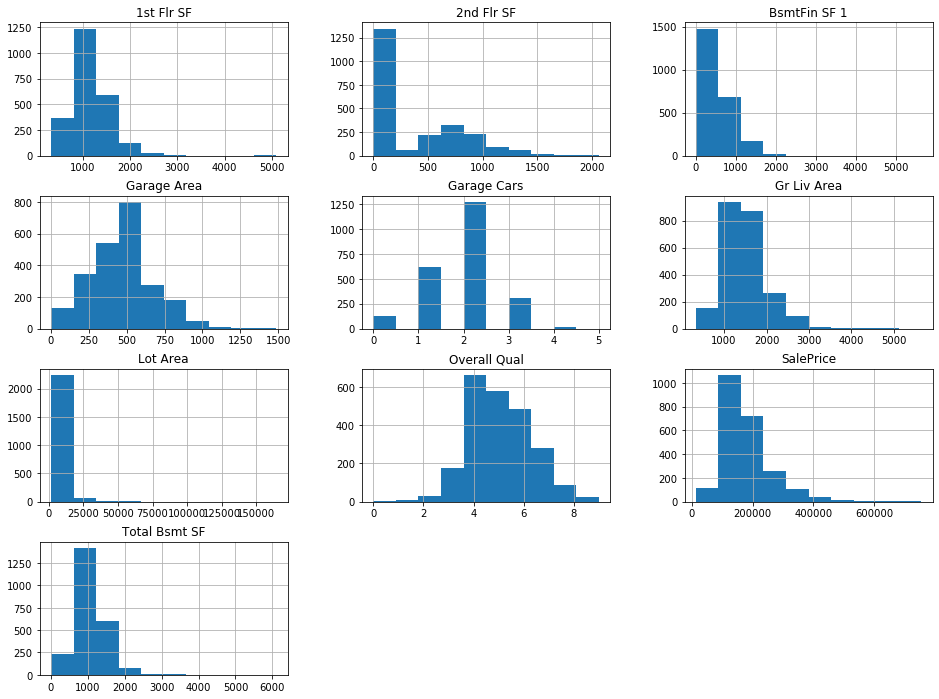

In [535]:
train_se.hist(figsize=(16,12));

In [539]:
train_se = train_se.sort_values(by="SalePrice")

In [544]:
train_se["SalePrice"]

181      12789
1553     13100
2880     35311
709      37900
1901     39300
         ...  
44      611657
1063    615000
2445    625000
1760    745000
1767    755000
Name: SalePrice, Length: 2340, dtype: int64

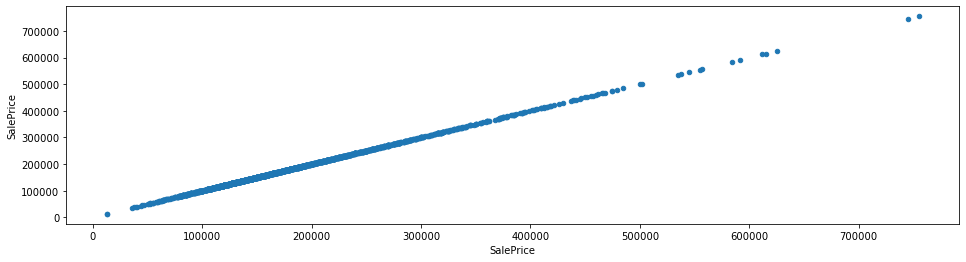

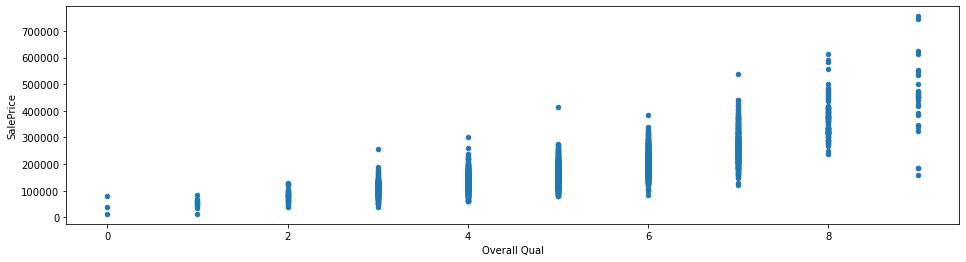

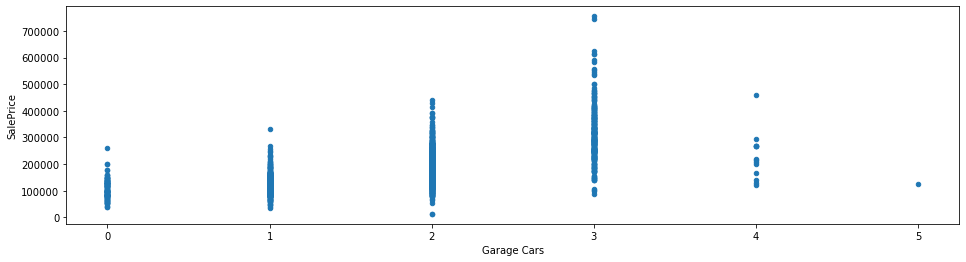

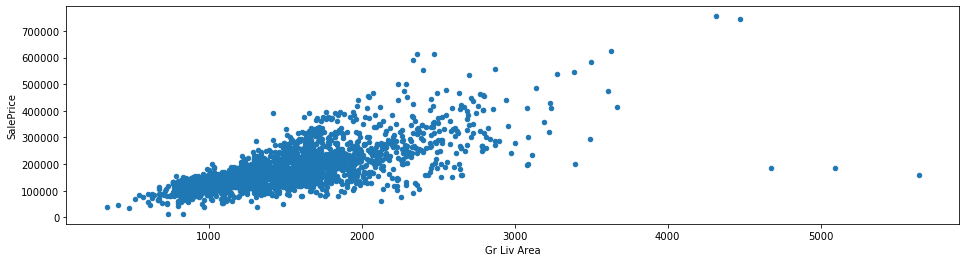

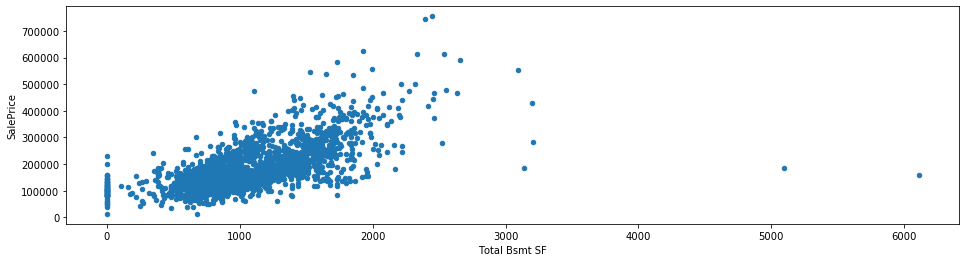

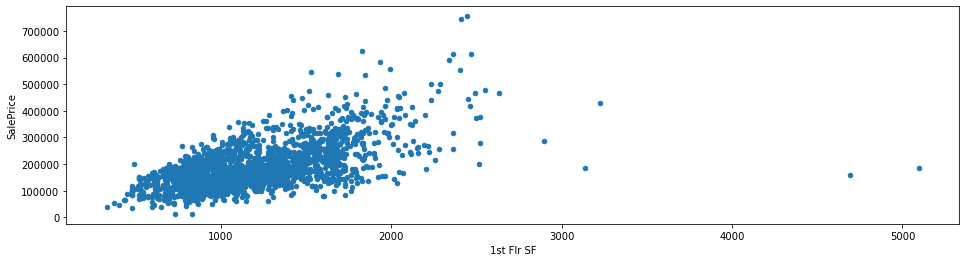

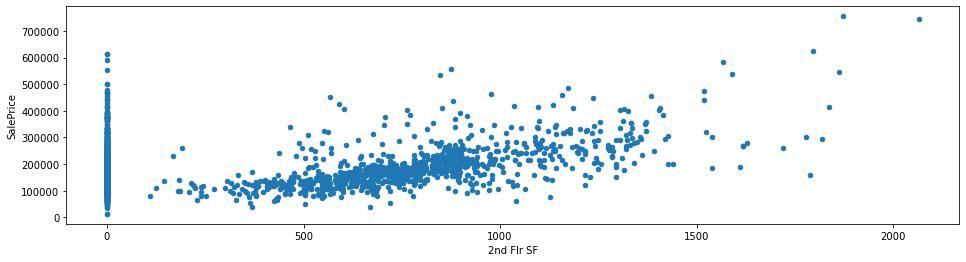

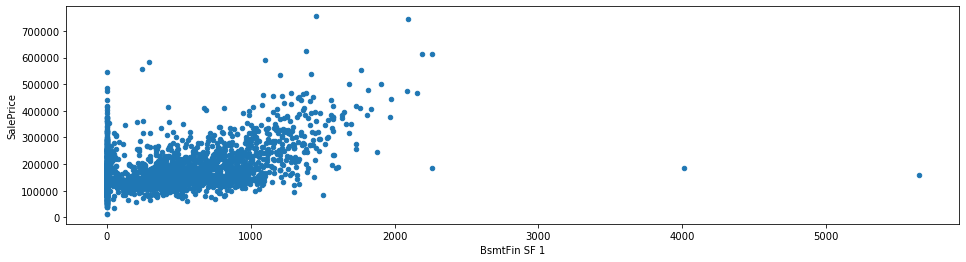

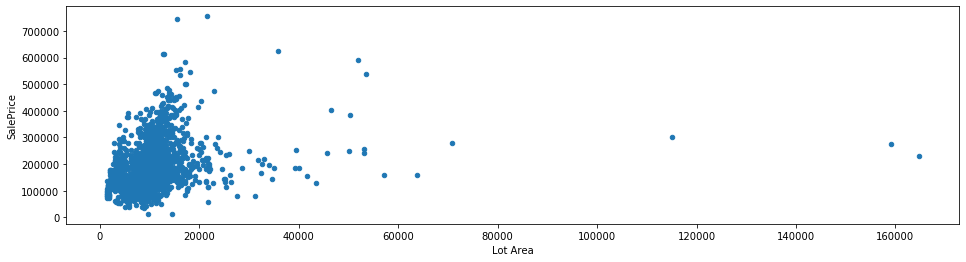

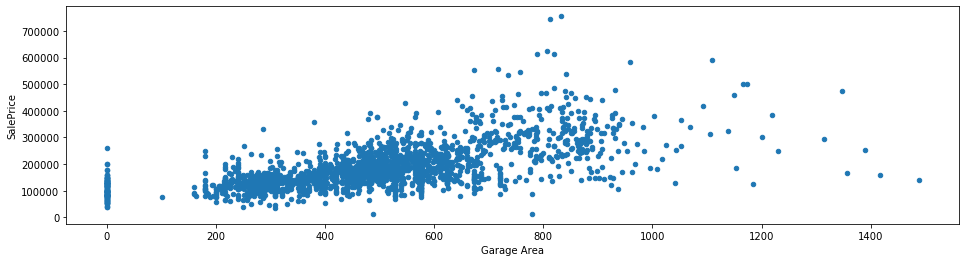

In [558]:
for col in train_se.columns:
    train_se.plot(kind="scatter", y="SalePrice", x=col)

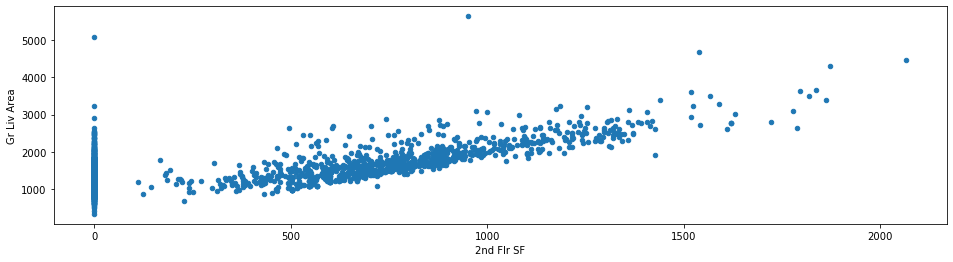

In [561]:
train_se.plot(kind="scatter", y="Gr Liv Area", x="2nd Flr SF")

In [563]:
train_se["1st+2nd SF"] = train_se["1st Flr SF"] + train_se["2nd Flr SF"]

In [569]:
train_se["1st+2nd+garage"] = train_se["1st Flr SF"] + train_se["2nd Flr SF"] + train_se["Garage Area"]

In [572]:
train_se.corr()["Total Bsmt SF"].sort_values()

2nd Flr SF       -0.195801
Lot Area          0.271387
Garage Cars       0.433009
Gr Liv Area       0.467821
1st+2nd SF        0.472137
Garage Area       0.488481
1st+2nd+garage    0.538896
BsmtFin SF 1      0.544692
Overall Qual      0.551306
SalePrice         0.629614
1st Flr SF        0.831114
1st+2nd+bsmt      0.836458
Total Bsmt SF     1.000000
Name: Total Bsmt SF, dtype: float64

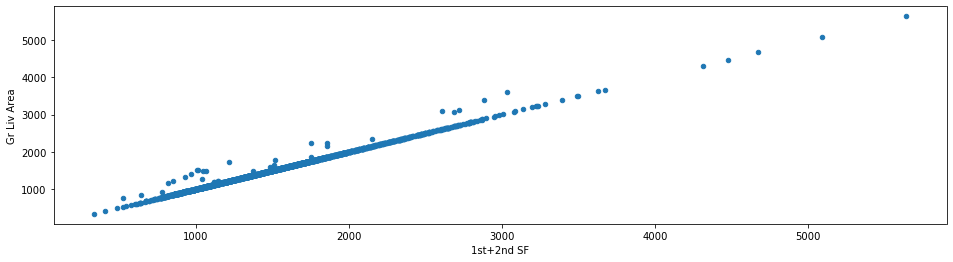

In [571]:
train_se.plot(kind="scatter", x="1st+2nd SF", y="Gr Liv Area")

In [578]:
train_se = train_se.iloc[:,:10]

In [587]:
train_se = train_se.drop(columns=["1st Flr SF", "2nd Flr SF"])

In [591]:
y = train_du[features["target"]].to_numpy().reshape(-1)
X = train_du.drop(columns=features["target"])

In [592]:
model_forest = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
cv_scores = cross_val_score(model_forest, X, y, cv=10, n_jobs=-1)
cv_scores.mean()

0.9008510391320366

In [ ]:
model_forest